In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import os
from scipy.io import savemat, loadmat

local_base_path = '/Users/bengieru/MLN/Results/general_diagnostics_00/'

import sys
sys.path.insert(0, local_base_path)

from helpers import *
from Temporal_Community_Detection import temporal_network

In [2]:
def space_comms(comm_size):
    lll = []
    rrr = []
    for c in comm_size:
        for i in range(random.randint(8,2*sum(comm_size))):
            lll.append(1)
            rrr.append(random.randint(10,30))
        lll.append(c)
        rrr.append(random.randint(10,30))
    return(lll,rrr)

def generate_transient(comm_per_layer):
    layer = len(comm_per_layer)
    comm_size = [[] for i in range(layer)]
    for i in range(layer):
        for j in range(comm_per_layer[i]):
            flag = True
            while flag:
                size = int(abs(np.random.normal(16,4)))
                if size > 8:
                    flag = False
            comm_size[i].append(int(size))
        
    num_neurons = int(max([sum(comm_size[i]) for i in range(len(comm_size))])*(2))
    
    comm_sizes = []
    spike_rate = []
    for c in comm_size:
        flag = True
        while flag:
            temp_size, temp_rate = space_comms(c)
            if sum(temp_size) < num_neurons:
                temp_rate = temp_rate + [random.randint(10,30) for j in range(num_neurons-sum(temp_size))]
                temp_size = temp_size + [1 for i in range(num_neurons-sum(temp_size))]
                comm_sizes.append(temp_size)
                spike_rate.append(temp_rate)
                flag = False
    return(comm_sizes, spike_rate, num_neurons)

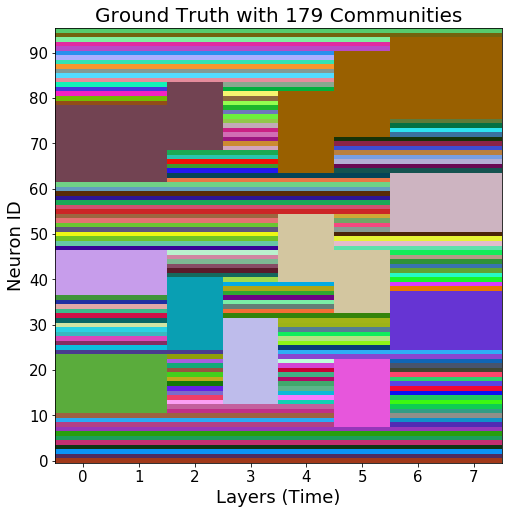

In [3]:
comm_per_layer = [3, 2, 1, 2, 3, 3]

layers = 6

#path = '/projects/academic/smuldoon/bengieru/Community_Detection/genereal_diagnostics_00/G_ESCR/'

local_path = local_base_path + 'T_GSCR/'
os.makedirs(local_path, exist_ok = True)

comm_sizes, spike_rates, num_neurons = generate_transient(comm_per_layer)

with open(local_path + "comm_size.pkl", "wb") as fp:
    pickle.dump(comm_sizes, fp)

bin_size = 1000.0 # in frames, in every bin_size, a community activity occurs
layers = len(comm_per_layer)
total_duration = int(layers*bin_size)
window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
pad = True

display_truth(comm_sizes, community_operation = 'transient')
plt.savefig(local_path + 'Ground_truths.pdf')

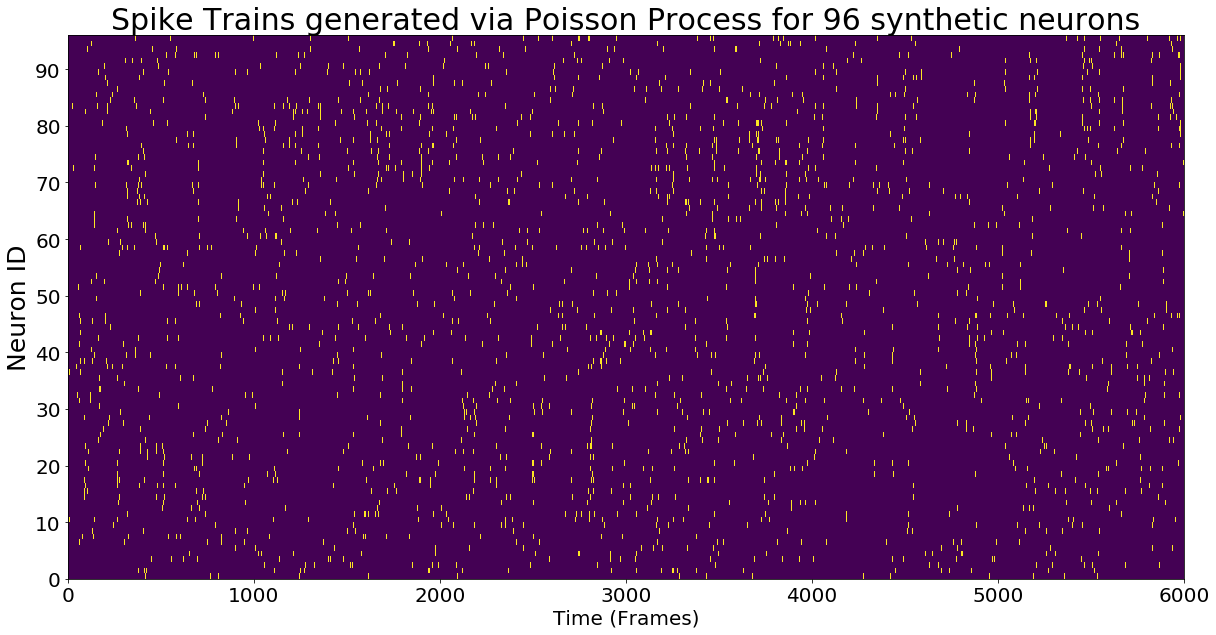

In [4]:
spikes = create_time_series('transient', comm_sizes, spike_rates, windowsize = window_size, k = k)
plt.savefig(local_path + 'spiketrain.pdf')

In [5]:
with open(local_path + "spikes.pkl", "wb") as fp:
    pickle.dump(spikes, fp)

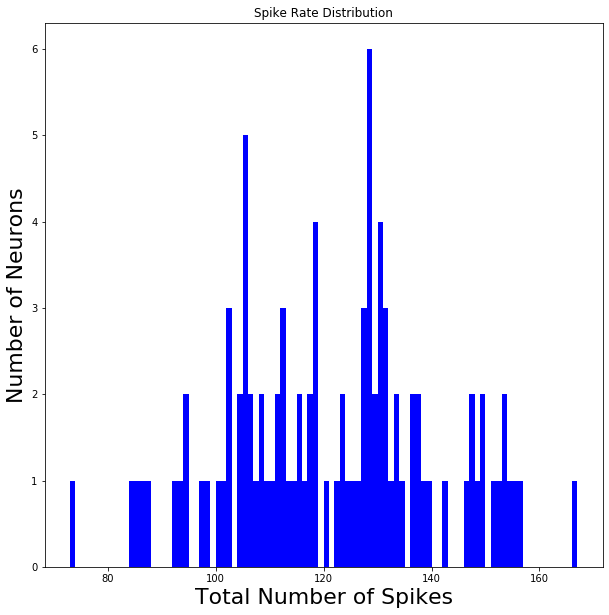

In [6]:
fig,ax = plt.subplots(1, 1, figsize = (10,10))
n, bins = spike_count(spikes, ax)
plt.savefig(local_path + 'spike_distribution.pdf')

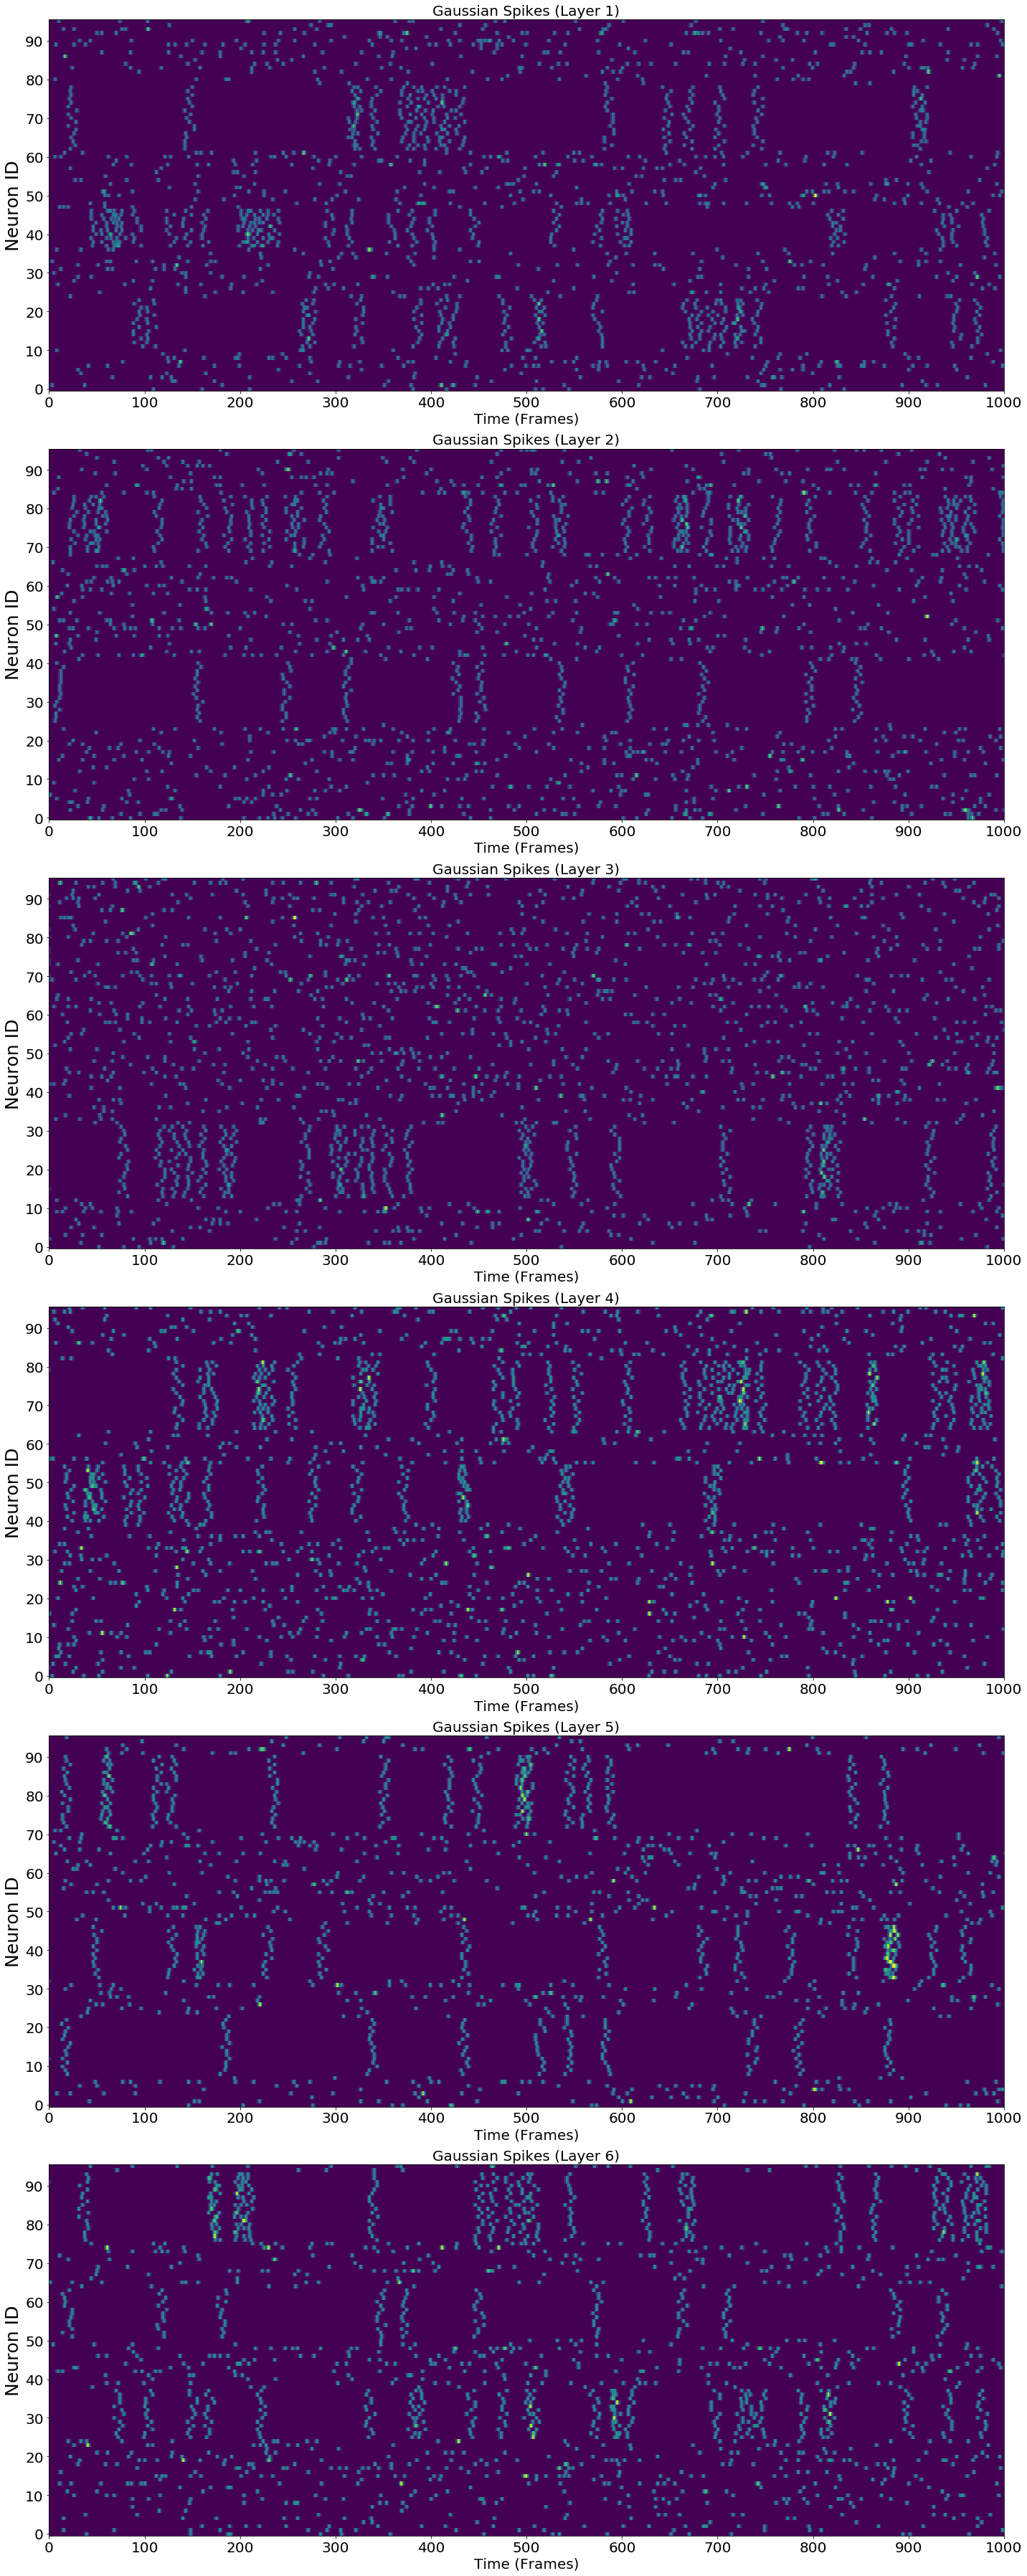

In [7]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers, 1, figsize=(20,50))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()
plt.savefig(local_path + 'binned_spiketrain.pdf')

In [8]:
if pad: layers = len(comm_sizes)+2

binned_spikes_T_GSCR = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)

adjacency_matrices = {}
for i in range(1,layers-1):
    adjacency_matrices['t%d'%i] = cross_correlation_matrix(binned_spikes_T_GSCR[i-1])[0]
if pad:
    adjacency_matrices['t%d'%0] = adjacency_matrices['t%d'%1]
    adjacency_matrices['t%d'%(layers-1)] = adjacency_matrices['t%d'%(layers-2)]

/Users/bengieru/MLN/Results/general_diagnostics_00/helpers.py:33: RuntimeWarning: invalid value encountered in sqrt
  x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
/Users/bengieru/MLN/Results/general_diagnostics_00/helpers.py:34: RuntimeWarning: invalid value encountered in sqrt
  y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))


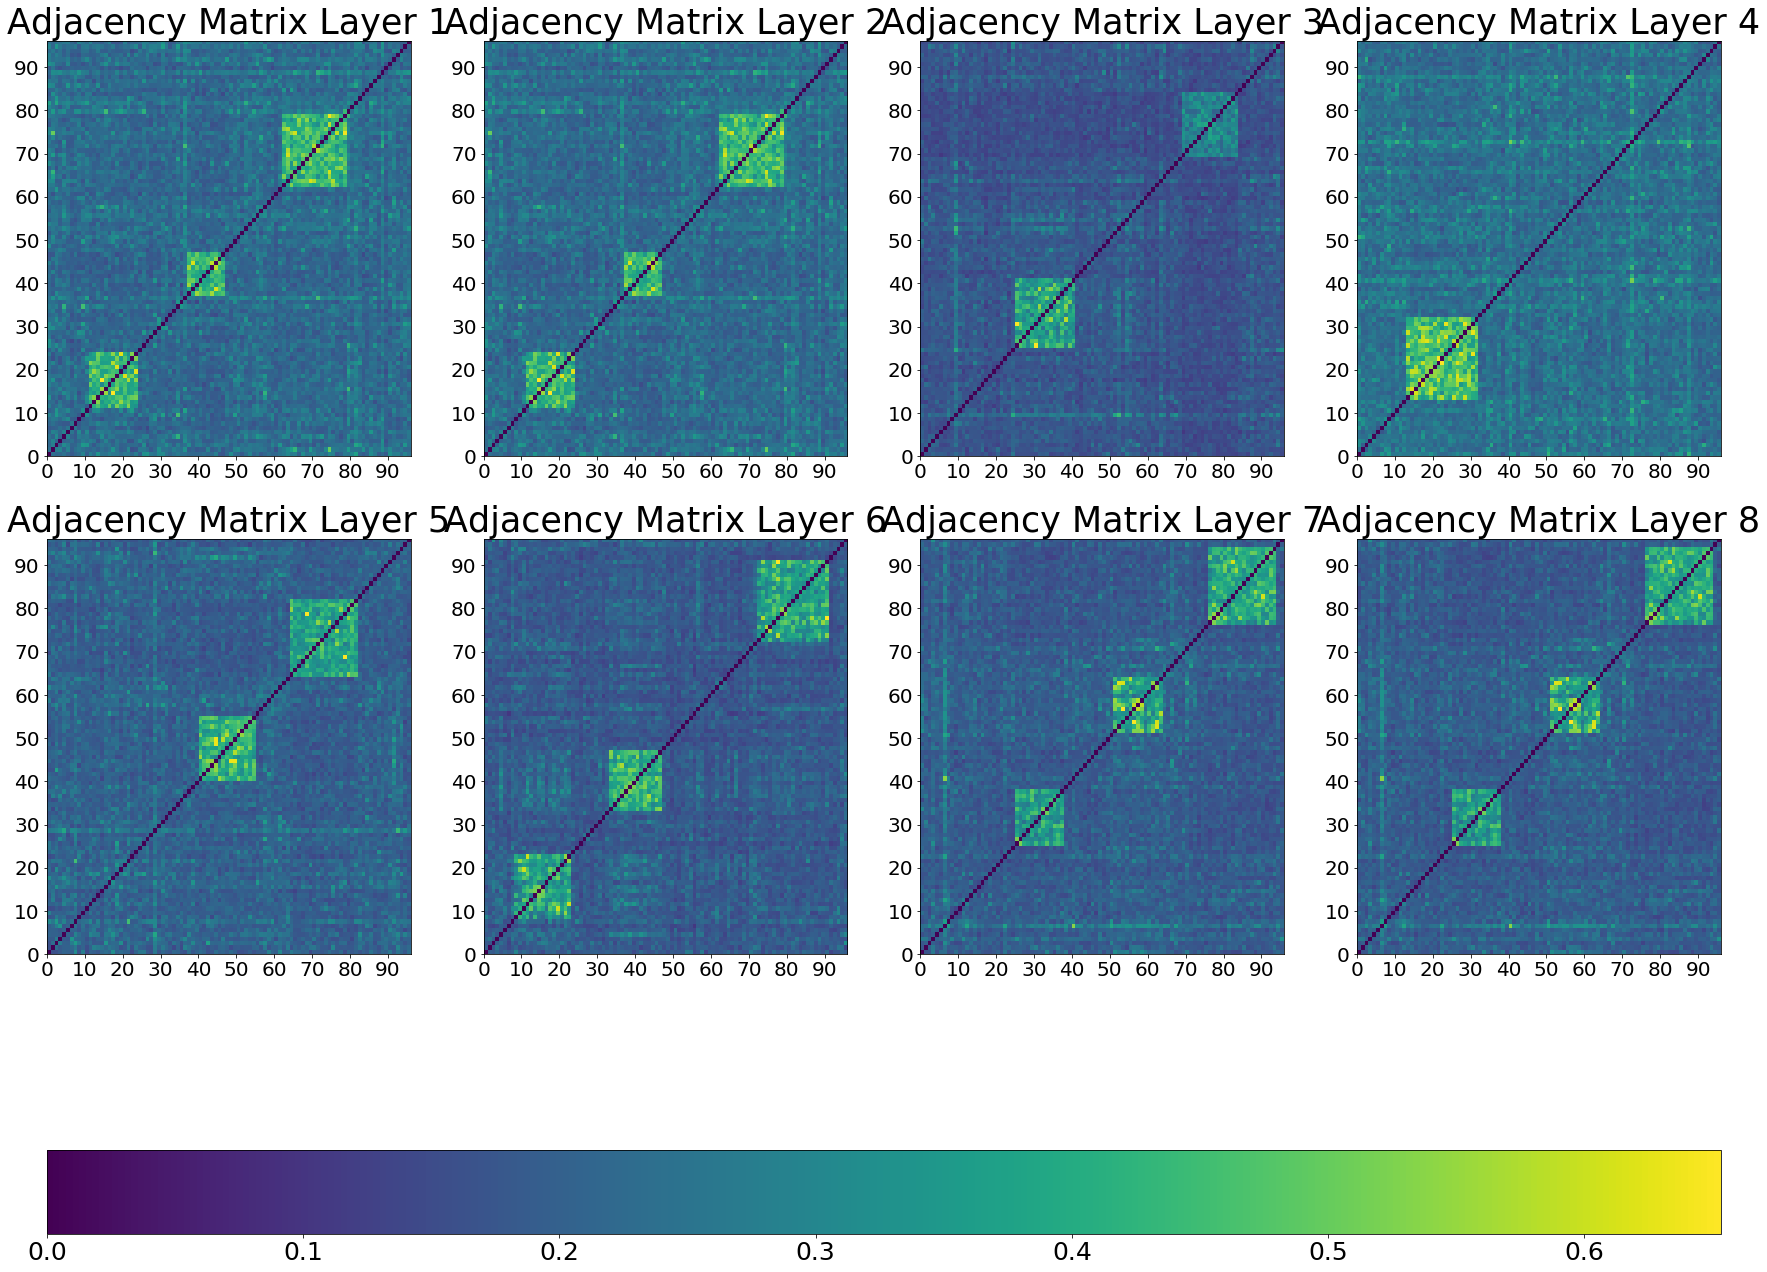

In [9]:
fig, ax = plt.subplots(2,4,figsize=(30,24))
for i in range(2):
    for j in range(4):
        k = ax[i][j].imshow(adjacency_matrices['t%d'%(i*4+j)], 
                            origin = 'lower', 
                            interpolation = 'nearest',
                            aspect = 'auto',
                            extent = [0,num_neurons,0,num_neurons])
        ax[i][j].set_title("Adjacency Matrix Layer %d"%(i*4+j+1), fontsize = 35)
        ax[i][j].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 20)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25)
plt.savefig(local_path + 'adjacencies.pdf')

In [10]:
thresholded_adjacencies = {}
threshs = np.linspace(0.05,0.6,12)
for i,e in enumerate(threshs):
    one_set = []
    for j in range(layers):
        one_set.append(binarize(adjacency_matrices['t%d'%j],e))
    thresholded_adjacencies['T%d'%i] = one_set
arr ={}
arr['TA'] = thresholded_adjacencies

In [11]:
savemat(local_path+'T_GSCR_adjacencies.mat', arr)